In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import requests

In [ ]:
MGYG-HGUT-02492
MGYG-HGUT-02506
MGYG-HGUT-01302
MGYG-HGUT-02438
MGYG-HGUT-02478
MGYG-HGUT-01346
MGYG-HGUT-00258
MGYG-HGUT-03694
MGYG-HGUT-00060
MGYG-HGUT-02321

## Loading and dealing with the metadata table

In [2]:
meta_data = pd.read_csv("41587_2020_603_MOESM3_ESM.csv")

In [3]:
meta_data.head()

,Species representative,MGnify accession,ENA accession,Status,Reference genes,Core genes1,% Core genes1,Accessory genes1,Pan-genome size1,Number of SNVs,...,Unnamed: 16,Unnamed: 17,Number of 97% ANI clusters,Number of 99% ANI clusters,Number of genomes (total),Number of genomes (non-redundant),Number of genomes (near-complete),Number of samples,Taxonomy lineage (GTDB),Taxonomy lineage (NCBI)
0,GUT_GENOME000001,MGYG-HGUT-00001,ERS3638031,Cultured (human gut),3182,NaN,NaN,NaN,NaN,16351.0,...,0,1,2,4,4,3,1,3,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
1,GUT_GENOME000004,MGYG-HGUT-00002,ERS3638032,Cultured (human gut),3920,1821.0,46.45,34621.0,36442.0,428560.0,...,49,162,134,327,358,308,120,308,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__L...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
2,GUT_GENOME000008,MGYG-HGUT-00003,ERS3638033,Cultured (human gut),2690,1522.0,56.58,19714.0,21236.0,516967.0,...,244,676,42,561,1178,1000,593,1003,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...
3,GUT_GENOME000010,MGYG-HGUT-00004,ERS3638034,Cultured (human gut),3634,NaN,NaN,NaN,NaN,58094.0,...,5,5,3,17,24,22,8,23,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__O...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
4,GUT_GENOME000017,MGYG-HGUT-00005,ERS3638035,Cultured (human gut),3755,NaN,NaN,NaN,NaN,NaN,...,0,0,1,2,2,2,1,2,d__Bacteria;p__Firmicutes_A;c__Clostridia;o__P...,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...


In [4]:
meta_data.sort_values('Number of genomes (near-complete)', ascending=False, inplace=True)

In [5]:
top_species = meta_data.iloc[:100, -1].apply(lambda x: ' '.join(x.split(';')[-2:]))

In [8]:
def find_species_row(meta_data, species_str):
    mask = meta_data.iloc[:, -1].apply(lambda x: species_str in x)
    return meta_data[mask]

In [21]:
# finding B. vulgatus (B. dorei)
find_species_row(meta_data, 'dorei')

,Species representative,MGnify accession,ENA accession,Status,Reference genes,Core genes1,% Core genes1,Accessory genes1,Pan-genome size1,Number of SNVs,...,Unnamed: 16,Unnamed: 17,Number of 97% ANI clusters,Number of 99% ANI clusters,Number of genomes (total),Number of genomes (non-redundant),Number of genomes (near-complete),Number of samples,Taxonomy lineage (GTDB),Taxonomy lineage (NCBI)
2477,GUT_GENOME143505,MGYG-HGUT-02478,ERS3640508,Cultured (human gut),4517,2259.0,50.01,192070.0,194329.0,842418.0,...,992,2343,276,2853,5750,3649,2090,3685,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__...,d__Bacteria;p__Bacteroidetes;c__Bacteroidia;o_...


In [15]:
row = find_species_row(meta_data, 'massiliensis')

In [15]:
row.iloc[:, -1]

2491    d__Bacteria;p__Firmicutes;c__Clostridia;o__Clo...
Name: Taxonomy lineage (NCBI), dtype: object

In [22]:
mgnify_accession = find_species_row(meta_data, 'rectale')['MGnify accession'].squeeze()
print("E. rectale's accession is {}".format(mgnify_accession))

E. rectale's accession is MGYG-HGUT-02492


In [16]:
def accession_to_species_name(accession):
    row = meta_data[meta_data['MGnify accession']==accession]
    return ';'.join(row['Taxonomy lineage (NCBI)'].item().split(';')[-2:])

In [17]:
accession_to_species_name('MGYG-HGUT-02321')

'g__Ruminococcus;s__'

## Downloading ref genome data

The '.faa' file is "All predicted CDS"

'fna' file is the "DNA sequence FASTA file of the genome assembly of the species representative"

A better way to download might be using the API, then we don't need to deal with the ftp address directly:
"https://www.ebi.ac.uk/metagenomics/api/v1/genomes/MGYG000000001/downloads/MGYG000000001.faa"

This is the same as using this website by hand:
https://www.ebi.ac.uk/metagenomics/genomes/MGYG000000001#downloads

However, these addresses are v2.0, so they have slightly different genome IDs: "MGYG-HGUT-00001" vs "MGYG000000001", for this reason I think we should download everything from the ftp address.

In [11]:
mgnify_accession = 'MGYG-HGUT-00001'

### Download using API

In [13]:
def accession_to_fileid(accession):
    # reformatting the id
    # my understanding is that we need to replace the HGUT part by 0000 and remove the -
    items = accession.split('-')
    return '0000'.join([items[0], items[-1]])

fileid = accession_to_fileid(mgnify_accession)
api_address = "https://www.ebi.ac.uk/metagenomics/api/v1/genomes/{}/downloads/".format(fileid)
filename = "{}.faa".format(fileid)

In [14]:
api_address + filename

'https://www.ebi.ac.uk/metagenomics/api/v1/genomes/MGYG000000001/downloads/MGYG000000001.faa'

In [15]:
import requests

# download the sequence and the annotation
filename = "{}.faa".format(fileid)
r = requests.get(api_address + filename)
open(filename, 'wb').write(r.content)

filename = "{}.fna".format(fileid)
r = requests.get(api_address + filename)
open(filename, 'wb').write(r.content)

### Download using ftp

In [19]:
# the ftp address has an upper level folder that omits the last two number of the accession id
ftp_base = "http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v1.0/uhgg_catalogue/{}/{}/genome/"
ftp_address = ftp_base.format(mgnify_accession[:-2], mgnify_accession)

In [20]:
print(ftp_address)

http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v1.0/uhgg_catalogue/MGYG-HGUT-000/MGYG-HGUT-00001/genome/


In [21]:
filename = "/Volumes/Botein/uhgg/reference_genomes/{}.fna".format(mgnify_accession)
r = requests.get(ftp_address + '{}.fna'.format(mgnify_accession))
open(filename, 'wb').write(r.content)

## Now let's check the SNV table
Let's verify that the reference genome makes sense

In [4]:
# download the SNV table
ftp_address = "http://ftp.ebi.ac.uk/pub/databases/metagenomics/mgnify_genomes/human-gut/v1.0/snv_catalogue/"
mgnify_accession = 'MGYG-HGUT-00001'

filename = "{}.tsv.tar.lz4".format(mgnify_accession)
r = requests.get(ftp_address + filename)
open(filename, 'wb').write(r.content)

Decompress in bash using: 
```
lz4 -dc < MGYG-HGUT-00001.tsv.tar.lz4 | tar xvf -
```

In [5]:
import pandas as pd
snv_df = pd.read_csv('MGYG-HGUT-00001_snvs.tsv', delimiter='\t')  # using the file uploaded to github repo

In [6]:
snv_df.head(10)

,Contig,Pos,Ref,Alt,GUT_GENOME091053,GUT_GENOME178957,GUT_GENOME212267
0,GUT_GENOME000001_106,1002,C,T,1,1,1
1,GUT_GENOME000001_106,1020,T,C,1,1,1
2,GUT_GENOME000001_106,1023,C,T,1,1,1
3,GUT_GENOME000001_106,1211,A,G,1,1,1
4,GUT_GENOME000001_106,1213,T,G,1,1,1
5,GUT_GENOME000001_106,1217,T,G,1,1,1
6,GUT_GENOME000001_106,1236,A,G,1,1,1
7,GUT_GENOME000001_106,1263,C,T,1,1,1
8,GUT_GENOME000001_106,1288,T,C,1,1,1
9,GUT_GENOME000001_106,1302,C,A,1,1,1


In [35]:
# let's check the first contig
desired_contig = snv_df.iloc[0, 0]

In [57]:
from Bio import SeqIO

# parsing the fasta file for ref seqeunce
# input_file = "{}.fna".format(mgnify_accession)
filename = "/Volumes/Botein/uhgg/reference_genomes/{}.fna".format(mgnify_accession)
input_file = filename
fasta_sequences = SeqIO.parse(open(input_file),'fasta')

In [58]:
all_records = []
for record in fasta_sequences:
    if record.id==desired_contig:
        desired_record = record
    all_records.append(record)
print(len(all_records))

1


In [47]:
contigs = [record.id for record in records]
seqs = [record.seq for record in records]

In [49]:
contig_seq_map = dict(zip(contigs, seqs))

In [44]:
print(desired_record.seq)
print("Contig length: {}".format(len(desired_record.seq)))

CCTAAAAATTTTATAATTTCGTTAGGCTTGTTTGCCATGCAAATTTTTAAAAATATGAAACTTAATTTAACCTATCGGTTTATTTATCAATTCGAGAATAATTCTCATCATATCTAATTAACAAAACCTAACTAAATATTTATTAATTCTAATCTTAAATCATTTAATATTGTCTTTGTTGCTCTTAATCTTATTTGCTGTCTATTTCCATTAAATACGTATCTCTTTACTATTATCTTTCCATTTATACAAATCCCAAAATATACCAAACCAACTGGTTTTTCTTCACTTCCACCTTCTGGTCCTGCTATTCCTGTTGTTGATAGCCCTATATTGGTATTATGCCTTTTAGCTATACCTTCTGCCATTTCTCTAGCTGTTTCCTCACTAACTGCTCCAAACTTATCTAGAGTTTCTTTTTTCACACCTAAAGATTTCATCTTAGCTTCATTGGAATAAGTTACACAACCTTCCATAAAAACAGATGAAATTCCTGGATAATTTATAAGGTGAGATGATACCATTCCTCCTGTACATGATTCTGCTACACTTATAGTTAAATTTTTATTAACTAAAATCTCAGCAACAGTATCTTCTAATGAAATATCACCCTCTGAATATATGTAACTTCCTACTCTATCTTGAATTTTATGTACAACTGGATTTATTAAATTAATAGCTTCTTCTTTACTAGTAGCTTTTGCTGTAATTCTTAAAGTTACTTCCGTGTCCTTTGCATATGGAGCTACAGTTGGATTTGATTGTTCTTTTATTATATCTATTATCTCTTCTTCTAAAGAAGATTCACCAATTCCATAGAATCTAAGAGTTTTAGAAACCAAAATTTCATTTGTTAAATTTTTTAAATATGGCTTAACATTTTCTTCGAACATTGGCTTCATTTCTCTTGGTGGGCCTGGTAATACTATTATTGTTTTTTTTCCTTTTCTTAAAATTGCTCCTGGTGCTGTACCATTGTTATTTTCAAGTATTATTGCAT

In [25]:
print("Downloaded ref, SNV table ref")
for _, row in snv_df.head(20).iterrows():
    # remember to change contig position to str index by subtracting 1 !!!
    # took me a while to realize this !!!
    print(desired_record.seq[int(row['Pos'])-1], row['Ref'])

Downloaded ref, SNV table ref
('C', 'C')
('T', 'T')
('C', 'C')
('A', 'A')
('T', 'T')
('T', 'T')
('A', 'A')
('C', 'C')
('T', 'T')
('C', 'C')
('A', 'A')
('C', 'C')
('C', 'C')
('A', 'A')
('T', 'T')
('C', 'C')
('A', 'A')
('T', 'T')
('A', 'A')
('A', 'A')


In [85]:
# check for E. rectale
gene_id = 14
snv_df = pd.read_csv('/Volumes/Botein/uhgg/{}/{}-{}.tsv'.format(mgnify_accession, contig, gene_id), delimiter='\t', header=None)
snv_df.columns = header.split('\t')

In [92]:
for gene_id in range(100):
    snv_df = pd.read_csv('/Volumes/Botein/uhgg/{}/{}-{}.tsv'.format(mgnify_accession, contig, gene_id), delimiter='\t', header=None)
    snv_df.columns = header.split('\t')
    for _, row in snv_df.iterrows():
        # remember to change contig position to str index by subtracting 1 !!!
        # took me a while to realize this !!!
        contig = row['Contig']
        ref_allele = seq[int(row['Pos'])-1]
        snv_table_allele = row['Ref']
        if ref_allele != snv_table_allele:
            print(row)

Now that we have checked that the reference sequence is indeed what's reported in the SNV table, the next step should be parsing the gene annotations.

## Processing the SNV tables
First step: split the SNV table by gene

In [31]:
import sys
sys.path.append('..')
import UHGG_utils

In [4]:
snvs_path = '/Volumes/Botein/uhgg/MGYG-HGUT-00001_snvs.tsv'
grouped_snvs_base = '/Volumes/Botein/uhgg/MGYG-HGUT-00001/'  # make sure to start with an empty folder
gene_df = UHGG_utils.gff_to_df('/Volumes/Botein/uhgg/MGYG-HGUT-00001.gff')

In [ ]:
UHGG_utils.process_SNVs_table(snvs_path, gene_df, grouped_snvs_base)

Second step: process each individual genes and compute all pairwise counts
I've done the above for the bigger table of E. rectale

In [54]:
mgnify_accession = 'MGYG-HGUT-02492'

In [55]:
reload(UHGG_utils)

<module 'UHGG_utils' from '../UHGG_utils.pyc'>

In [56]:
snvs_path = '/Volumes/Botein/uhgg/MGYG-HGUT-02492_snvs.tsv'
grouped_snvs_base = '/Volumes/Botein/uhgg/MGYG-HGUT-02492/'  # make sure to start with an empty folder
gene_df = UHGG_utils.gff_to_df('/Volumes/Botein/uhgg/MGYG-HGUT-02492.gff')
gene_df = gene_df.set_index('Gene ID')
genomes_metadata = pd.read_csv('/Volumes/Botein/uhgg/genomes-nr_metadata.tsv', delimiter='\t')

/Users/Device6/.pyenv/versions/microbiome/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
# load the header that contains all the sample names
header = UHGG_utils.get_SNVs_table_header(snvs_path)
genome_names = UHGG_utils.get_genome_names_from_table_header(header)
genome_mask = UHGG_utils.get_non_redundant_genome_mask(genomes_metadata, mgnify_accession, genome_names)

In [12]:
reload(UHGG_utils)

<module 'UHGG_utils' from '../UHGG_utils.py'>

In [13]:
core_genes = UHGG_utils.load_core_genes(mgnify_accession)

In [19]:
core_genes = [int(x) for x in core_genes]

In [25]:
from datetime import datetime
gene_files = os.listdir(grouped_snvs_base)

output_path = '/Volumes/Botein/uhgg/E_rectale_site_pairs_083022.txt'
with open(output_path, 'w') as f:
    f.write(' '.join(('n11', 'n10', 'n01', 'n00', 'ell')) + '\n')

processed = 0

for gene_file in gene_files:
    gene_file_path = grouped_snvs_base + gene_file
    items = gene_file.split('.')[0].split('-')
    gene_id = int(items[-1])
    contig = items[0]
    if processed % 100 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Finished {} at {}".format(processed, current_time))
    processed += 1
    if gene_df.loc[gene_id, 'Type'] != 'CDS':
        continue
    elif gene_id not in core_genes:
        continue
    UHGG_utils.process_SNV_table_single_gene(mgnify_accession, header, genomes_metadata, gene_file_path, contig, gene_id, output_path)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Finished {} at {}".format(processed, current_time))

Finished 0 at 21:50:12
Finished 100 at 21:52:57
Finished 200 at 21:54:29
Finished 300 at 21:56:39
Finished 400 at 22:01:37
Finished 500 at 22:09:19
Finished 600 at 22:17:17
Finished 700 at 22:23:00
Finished 800 at 22:28:55
Finished 900 at 22:34:25
Finished 1000 at 22:39:02
Finished 1100 at 22:39:02
Finished 1200 at 22:42:24
Finished 1300 at 22:49:35
Finished 1400 at 22:55:22
Finished 1500 at 22:58:46
Finished 1600 at 23:02:50
Finished 1700 at 23:04:04
Finished 1800 at 23:05:40
Finished 1900 at 23:08:17
Finished 2000 at 23:11:44
Finished 2100 at 23:12:48
Finished 2200 at 23:13:47
Finished 2300 at 23:15:19
Finished 2400 at 23:16:19
Finished 2500 at 23:16:19
Finished 2600 at 23:16:31
Finished 2700 at 23:16:31
Finished 2800 at 23:19:04
Finished 2900 at 23:24:44
Finished 3000 at 23:25:11
Finished 3100 at 23:29:29
Finished 3200 at 23:30:29
Finished 3300 at 23:32:22
Finished 3400 at 23:36:23
Finished 3429 at 23:38:44


In [64]:
reload(UHGG_utils)

<module 'UHGG_utils' from '../UHGG_utils.py'>

In [65]:
# now process pairs of random genes
gene_files = os.listdir(grouped_snvs_base)

output_path = '/Volumes/Botein/uhgg/E_rectale_site_pairs_083022.txt'
n_pairs = 1000
for i in range(n_pairs):
    gene1, gene2 = UHGG_utils.sample_random_pair_of_genes(gene_files, core_genes, gene_df)
    gene_file_path1 = grouped_snvs_base + gene1
    gene_file_path2 = grouped_snvs_base + gene2
    if i % 100 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Finished {} at {}".format(i, current_time))
    UHGG_utils.process_SNV_table_between_genes(gene_file_path1, gene_file_path2, genome_mask, output_path)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Finished {} at {}".format(i, current_time))

Finished 0 at 11:09:36
Finished 100 at 11:18:08
Finished 200 at 11:27:33
Finished 300 at 11:37:04
Finished 400 at 11:46:45
Finished 500 at 11:56:57
Finished 600 at 12:07:07
Finished 700 at 12:15:20
Finished 800 at 12:23:30
Finished 900 at 12:31:54
Finished 999 at 12:40:47


Use the below codes to load the final results and resave into a numpy binary format for faster future loading

In [66]:
# very slow to parse the csv using np; slightly faster if using pandas; best to resave into binary format like npy!
output_path = '/Volumes/Botein/uhgg/E_rectale_site_pairs_083022.txt'
res = pd.read_csv(output_path, delimiter=' ')

In [67]:
res = res.to_numpy()

In [68]:
np.save('/Volumes/Botein/uhgg/E_rectale_site_pairs_083022', res)

In [4]:
%%time
res = np.load('/Volumes/Botein/uhgg/E_rectale_site_pairs.npy')

CPU times: user 2.32 ms, sys: 6.52 s, total: 6.52 s
Wall time: 10.8 s


## Converting Ben's data

In [1]:
%%time
import gzip
file = gzip.GzipFile('../erectale_snv_pairs.txt.gz',"r")


file.readline() # header

n11s = []
n10s = []
n01s = []
n00s = []
ells = []
print "Loading data..."
for line in file:
    
    items = line.split()
    n11 = long(items[0])
    n10 = long(items[1])
    n01 = long(items[2])
    n00 = long(items[3])
    ell = long(items[4])

    n11s.append(n11)
    n10s.append(n10)
    n01s.append(n01)
    n00s.append(n00)
    ells.append(ell)

file.close()

Loading data...
CPU times: user 2min 30s, sys: 5.71 s, total: 2min 36s
Wall time: 2min 44s


In [ ]:
import sys
sys.sizeof(n11s)

In [ ]:
import numpy
n11s =numpy.array(n11s)*1.0
n10s = numpy.array(n10s)*1.0
n01s = numpy.array(n01s)*1.0
n00s = numpy.array(n00s)*1.0
ntots = n11s+n10s+n01s+n00s
ells = numpy.array(ells)

In [ ]:
ns = np.concatenate([n11s, n10s, n01s, n00s, ells])

## Scratch space

In [6]:
gene_files = os.listdir(grouped_snvs_base)

In [53]:
mgnify_accession = 'MGYG-HGUT-02492'
species_accession = mgnify_accession
header = UHGG_utils.get_SNVs_table_header(snvs_path)
genome_names = header.split('\t')[4:]
genome_mask = UHGG_utils.get_non_redundant_genome_mask(genomes_metadata, species_accession, genome_names)
num_genomes = genome_mask.sum()

NameError: name 'snvs_path' is not defined

In [46]:
cumu_pair_snvs = np.zeros((num_genomes, num_genomes))
cumu_pair_passed = np.zeros((num_genomes, num_genomes))
cumu_diff_genes = np.zeros((num_genomes, num_genomes))
cumu_passed_genes = np.zeros((num_genomes, num_genomes))

In [61]:
# script to compute pairwise distance
from datetime import datetime
processed = 0
total_sites = 0

for gene_file in gene_files:
    gene_file_path = grouped_snvs_base + gene_file
    items = gene_file.split('.')[0].split('-')
    gene_id = int(items[-1])  # this gene id is assigned by us according to the reference genome's annotation order
    contig = items[0]
    if gene_df.loc[gene_id, 'Type'] != 'CDS':
        continue
    elif str(gene_id) not in species_core_genes:
        # check if gene is a "core gene"
        continue
    
    # load SNV table
    dat = pd.read_csv(gene_file_path, delimiter='\t', header=None)
    dat.columns = header.split('\t')
    dat.sort_values('Pos', inplace=True)

    # filtering sites with more than two alleles
    biallelic_dat = dat.groupby('Pos').filter(lambda x: x.shape[0] == 1)

    # converting to numpy array for faster arithmetics
    snvs = biallelic_dat.iloc[:, 4:].astype(int).to_numpy()
    snvs = snvs[:, genome_mask]

    zeros = (snvs == 0).astype(int)
    ones = (snvs == 1).astype(int)
    covered = (snvs != 255).astype(int)
    
    pair_snvs = np.dot(zeros.T, ones)  # using dot product to count the number of sites that are different
    pair_snvs = pair_snvs + pair_snvs.T
    pair_passed = np.dot(covered.T, covered)
    
    total_sites += snvs.shape[0]
    cumu_pair_snvs += pair_snvs
    cumu_pair_passed += pair_passed  # record the number of covered sites between a pair
    cumu_diff_genes += pair_snvs > 0  # record if a pair has non identical genes
    cumu_passed_genes += pair_passed > 0 # record if a gene has any covered sites between a pair
    
    if processed % 10 == 0:
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print("Finished {} at {}".format(processed, current_time))
    processed += 1

Finished 0 at 13:58:12
Finished 10 at 14:00:29
Finished 20 at 14:02:55
Finished 30 at 14:05:15
Finished 40 at 14:07:00
Finished 50 at 14:09:20
Finished 60 at 14:11:40
Finished 70 at 14:14:44
Finished 80 at 14:17:33
Finished 90 at 14:20:05
Finished 100 at 14:22:26
Finished 110 at 14:24:28
Finished 120 at 14:26:40
Finished 130 at 14:28:42
Finished 140 at 14:30:31
Finished 150 at 14:32:47
Finished 160 at 14:35:27
Finished 170 at 14:38:45
Finished 180 at 14:42:35
Finished 190 at 14:45:52
Finished 200 at 14:48:19
Finished 210 at 14:50:43
Finished 220 at 14:53:09
Finished 230 at 14:55:04
Finished 240 at 14:57:18
Finished 250 at 14:59:25
Finished 260 at 15:01:34
Finished 270 at 15:03:52
Finished 280 at 15:05:26
Finished 290 at 15:07:41
Finished 300 at 15:10:28
Finished 310 at 15:12:50
Finished 320 at 15:15:12
Finished 330 at 15:18:17
Finished 340 at 15:21:06
Finished 350 at 15:23:16
Finished 360 at 15:26:11
Finished 370 at 15:28:02
Finished 380 at 15:30:44
Finished 390 at 15:33:05
Finished 40

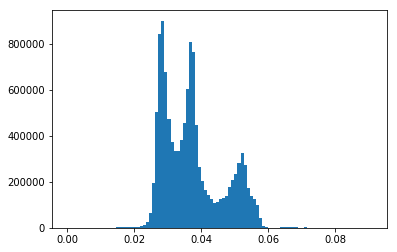

In [9]:
uptri = np.triu_indices(cumu_diff_genes.shape[0], k=1)
divs = cumu_pair_snvs[uptri] / cumu_pair_passed[uptri]
_ = plt.hist(divs, bins=100)

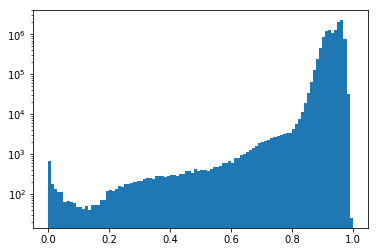

In [10]:
diff_frac = cumu_diff_genes[uptri] / cumu_passed_genes[uptri]
_ = plt.hist(diff_frac, bins=100)
plt.yscale('log')

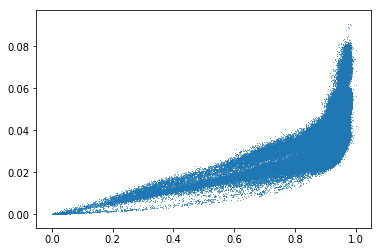

In [11]:
plt.scatter(diff_frac, divs, s=0.6, linewidth=0, rasterized=True)

In [70]:
np.save('/Volumes/Botein/uhgg/pairwise_distances/{}/pair_snvs'.format(mgnify_accession), cumu_pair_snvs)
np.save('/Volumes/Botein/uhgg/pairwise_distances/{}/pair_passed'.format(mgnify_accession), cumu_pair_passed)
np.save('/Volumes/Botein/uhgg/pairwise_distances/{}/diff_genes'.format(mgnify_accession), cumu_diff_genes)
np.save('/Volumes/Botein/uhgg/pairwise_distances/{}/passed_genes'.format(mgnify_accession), cumu_passed_genes)

In [8]:
cumu_pair_snvs = np.load('/Volumes/Botein/uhgg/pairwise_distances/{}/pair_snvs.npy'.format(mgnify_accession))
cumu_pair_passed = np.load('/Volumes/Botein/uhgg/pairwise_distances/{}/pair_passed.npy'.format(mgnify_accession))
cumu_diff_genes = np.load('/Volumes/Botein/uhgg/pairwise_distances/{}/diff_genes.npy'.format(mgnify_accession))
cumu_passed_genes = np.load('/Volumes/Botein/uhgg/pairwise_distances/{}/passed_genes.npy'.format(mgnify_accession))

In [205]:
from Bio import SeqIO

core_gene_file = '/Users/Device6/Documents/Research/bgoodlab/UHGG/E_rectale_core_genes.faa'
# core_gene_file = '/Users/Device6/Documents/Research/bgoodlab/UHGG/B_vulgatus_core_genes.faa'
pangenome_file = '/Users/Device6/Documents/Research/bgoodlab/UHGG/E_rectale_pan-genome.faa'
core_gene_name_file = '/Users/Device6/Documents/Research/bgoodlab/UHGG/E_rectale_core_genes.txt'

fasta_sequences = SeqIO.parse(open(core_gene_file),'fasta')
# fasta_sequences = SeqIO.parse(open(pangenome_file),'fasta')

In [26]:
reload(UHGG_utils)

<module 'UHGG_utils' from '../UHGG_utils.py'>

In [27]:
coverage_array, gene_files = UHGG_utils.compute_gene_SNV_coverage(grouped_snvs_base, genome_mask, debug=False)

Finished 0 at 12:26:55
Finished 100 at 12:29:07
Finished 200 at 12:31:09
Finished 300 at 12:33:01
Finished 400 at 12:35:24
Finished 500 at 12:37:52
Finished 600 at 12:40:16
Finished 700 at 12:42:34
Finished 800 at 12:44:53
Finished 900 at 12:47:29
Finished 1000 at 12:49:47
Finished 1100 at 12:51:20
Finished 1200 at 12:53:27
Finished 1300 at 12:56:00
Finished 1400 at 12:58:21
Finished 1500 at 13:00:28
Finished 1600 at 13:02:50
Finished 1700 at 13:04:34
Finished 1800 at 13:06:19
Finished 1900 at 13:08:24
Finished 2000 at 13:10:49
Finished 2100 at 13:12:52
Finished 2200 at 13:15:16
Finished 2300 at 13:17:09
Finished 2400 at 13:18:59
Finished 2500 at 13:20:44
Finished 2600 at 13:22:40
Finished 2700 at 13:24:20
Finished 2800 at 13:26:36
Finished 2900 at 13:29:05
Finished 3000 at 13:31:03
Finished 3100 at 13:33:19
Finished 3200 at 13:35:08
Finished 3300 at 13:37:11
Finished 3400 at 13:39:34


In [43]:
import json
species_core_genes = UHGG_utils.get_species_core_genes(coverage_array, gene_files)
np.save('/Volumes/Botein/uhgg/core_genes/{}/SNV_coverage'.format(mgnify_accession), coverage_array)
json.dump(list(gene_files), open('/Volumes/Botein/uhgg/core_genes/{}/gene_files.json'.format(mgnify_accession), 'w'))
json.dump(list(species_core_genes), open('/Volumes/Botein/uhgg/core_genes/{}/core_genes.json'.format(mgnify_accession), 'w'))

(array([ 886.,  178.,  130.,  102.,   97.,  104.,  176.,  163.,  311.,
        1282.]),
 array([4.10593307e-04, 9.79675631e-02, 1.95524533e-01, 2.93081503e-01,
        3.90638473e-01, 4.88195442e-01, 5.85752412e-01, 6.83309382e-01,
        7.80866352e-01, 8.78423322e-01, 9.75980292e-01]),
 <a list of 10 Patch objects>)

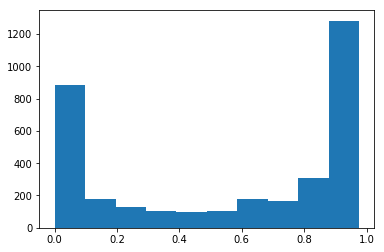

In [37]:
plt.hist((coverage_array>0.5).mean(axis=1))

In [257]:
np.sum((coverage_array>0.5).mean(axis=1) > 0.9)

1129

In [29]:
import random
def sample_random_pair_of_genes(files):
    while True:
        file1, file2 = random.sample(files, 2)
        id1 = int(file1.split('.')[0].split('-')[-1])
        id2 = int(file2.split('.')[0].split('-')[-1])
        if np.abs(id1-id2) < 15:
            continue
        if (id1 in core_genes) and (id2 in core_genes):
            return file1, file2

In [51]:
UHGG_utils.sample_random_pair_of_genes(gene_files, core_genes, gene_df)

('GUT_GENOME143712_1-1801.tsv', 'GUT_GENOME143712_1-1520.tsv')

In [36]:
header.split('\t')[4]

'GUT_GENOME000061'